In [1]:
import glob
import skimage
import os
from skimage import io
import matplotlib
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
import numpy as np
from tensorflow.contrib.layers import fully_connected
from tensorflow.contrib.metrics import f1_score
from skimage.transform import rescale, resize
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import time

from sklearn.utils import shuffle

Creating the training and testing sets

In [2]:
dogs_races = glob.glob('/home/ficiu/Desktop/Train_data/Caini/Cu rasa/*')
cats_races = glob.glob('/home/ficiu/Desktop/Train_data/Pisici/Cu rasa/*')
dogs_without_race=glob.glob('/home/ficiu/Desktop/Train_data/Caini/Fara rasa/*')
cats_without_race=glob.glob('/home/ficiu/Desktop/Train_data/Pisici/Fara rasa/*')

In [3]:
def appendingFunction(X_dataset,y_dataset,thelist):
    for each in thelist:
        for i in glob.glob(each+'*'):
            X_dataset.append(i)
            y_races.append(each.split('/')[-1])
    return X_dataset,y_dataset

In [4]:
X_cats_dogs=[]
y_cats_dogs=[]

X_races=[]
y_races=[]
z_races=[]

X_races,y_races=appendingFunction(X_races,y_races,dogs_races)
X_races,y_races=appendingFunction(X_races,y_races,cats_races)

In [5]:
count_dogs=0
count_cats=0
for each in dogs_races:
    for i in glob.glob(each+'/*'):
        X_cats_dogs.append(i)
        y_cats_dogs.append('1')
        count_dogs+=1
        
for each in cats_races:
    for i in glob.glob(each+'/*'):
        X_cats_dogs.append(i)
        y_cats_dogs.append('0')
        count_cats+=1
        
for each in dogs_without_race:
    X_cats_dogs.append(each)
    y_cats_dogs.append('1')
    count_dogs+=1

for each in cats_without_race:
    X_cats_dogs.append(each)
    y_cats_dogs.append('0')
    count_cats+=1

for each in cats_without_race:
    X_cats_dogs.append(each)
    y_cats_dogs.append('0')
    count_cats+=1

for each in cats_races:
    for i in glob.glob(each+'/*'):
        X_cats_dogs.append(i)
        y_cats_dogs.append('0')
        count_cats+=1
    
print(count_dogs-count_cats,count_cats)
X_cats_dogs, y_cats_dogs = shuffle(X_cats_dogs, y_cats_dogs)
X_cats_dogs=X_cats_dogs
y_cats_dogs=y_cats_dogs

-1439 49866


Choosing the kernel size for the first convolutional layer

In [6]:
poza_resized = resize(io.imread(X_cats_dogs[1]),(100,100),anti_aliasing=True)
for i in range(100):
    for j in range(100):
        if(i==20 and j>=25 and j<=65) or (i==70 and j>=25 and j<=65) or (j==25 and i>=20 and i<=70) or (j==65 and i>=20 and i<=70):
            poza_resized[i, j, 1] = 0
            poza_resized[i, j, 2] = 0
            poza_resized[i,j,0]=255

/home/ficiu/anaconda3/envs/python3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


/home/ficiu/anaconda3/envs/python3.6/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


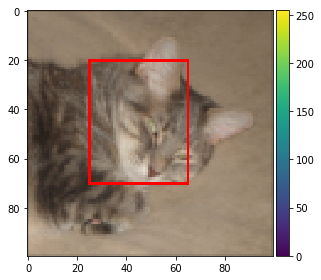

In [7]:
io.imshow(poza_resized)

In [8]:
def create_weights_vector(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def create_biases_vector(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [9]:
def create_convolutional_Layer(input, channels, filter_x, filter_y, num_filters, stride, with_Pooling=True):
    shape = [filter_x, filter_y, channels, num_filters]
    # Create new weights aka. filters with the given shape.
    weights = create_weights_vector(shape=shape)
    print(weights.shape)
    # Create new biases, one for each filter.
    biases = create_biases_vector(length=num_filters)
    layer = tf.nn.conv2d(input=input,filter=weights,strides=[1, stride, stride, 1],padding='SAME')
    layer += biases
    if with_Pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
    layer = tf.nn.leaky_relu(layer)
    return layer, weights

In [10]:
def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

In [11]:
def new_fc_layer(input,
                 num_inputs,   
                 num_outputs,   
                 use_Leaky_relu=True): 

    weights = create_weights_vector(shape=[num_inputs, num_outputs])
    biases = create_biases_vector(length=num_outputs)
    layer = tf.matmul(input, weights) + biases

    #Leaky_relu
    if use_Leaky_relu:
        layer = tf.nn.leaky_relu(layer)

    return layer



In [12]:
def CrossValidation(X_dataset,y_dataset,currentPosition,batch_size):
    try:
        return X_dataset[currentPosition:currentPosition+batch_size],y_dataset[currentPosition:currentPosition+batch_size]
    
    except:
        return X_dataset[currentPosition:],y_dataset[currentPosition:]

In [13]:
def prepare_batch(batch_size ,startPointInDataset ,X_dataset ,Y_dataset ,pic_width, pic_height):
    x_batch=np.zeros(batch_size*pic_width*pic_height*3).reshape(batch_size, pic_width, pic_height,3) #pregatit forma matricei de input
    y_batch=np.zeros(batch_size)   #pregatit forma matricei label
    
    #Daca Batchsizeul + starting position > lungimea datasetului
    #Micesc Batchsizeul si antrenez pe ce o ramas
    if(startPointInDataset+batch_size>len(X_dataset)):
        newBatchSize=len(X_dataset)-startPointInDataset
        x_batch,y_batch=prepare_batch(newBatchSize,startPointInDataset,X_dataset,Y_dataset,pic_width, pic_height)
    else:
        i=0
        while i < batch_size:
            #Citesc poza
            try:
                poza_resized = resize(io.imread(X_cats_dogs[startPointInDataset+i]),(pic_height,pic_width),anti_aliasing=True)
                if(poza_resized.flatten().shape[0]==pic_height*pic_width*3):
                    x_batch[i]=poza_resized
                    y_batch[i]=y_cats_dogs[startPointInDataset+i]
                
            except:
                print("POZA: ", X_cats_dogs[startPointInDataset:startPointInDataset+batch_size][i], "Nu e buna")
                if(i>0):
                    x_batch[i]=x_batch[i-1]
                    y_batch[i]=y_batch[i-1]
            i+=1
    return x_batch , y_batch

In [14]:
Kernelshape=(50,40)
Kernelshape1=(25,20)
Kernelshape2=(5,5)
Kernelshape3=(5,5)
num_filters=25
num_filters1=50
num_filters2=50
num_filters3=50

fullyconnected=200
fullyconnected1=2
stride=1
image_size=(100,100,3)

In [15]:
#Input and output placeholders
tf.reset_default_graph
X=tf.placeholder(tf.float32,shape=(None,image_size[0],image_size[1],3),name="X")
y=tf.placeholder(tf.int64,shape=(None),name="y")

In [16]:
layer_conv1, weights_conv1 = create_convolutional_Layer(input=X ,channels=image_size[2],filter_x=Kernelshape[0],filter_y=Kernelshape[1] ,num_filters=num_filters ,stride=1,with_Pooling=True)
layer_conv2, weights_conv2 = create_convolutional_Layer(input= layer_conv1, channels=num_filters,filter_x=Kernelshape1[0],filter_y=Kernelshape1[1],num_filters=num_filters1,stride=1,with_Pooling=True)
layer_conv3, weights_conv3 = create_convolutional_Layer(input= layer_conv2, channels=num_filters1,filter_x=Kernelshape2[0],filter_y=Kernelshape2[1],num_filters=num_filters2,stride=1,with_Pooling=True)
layer_conv4, weights_conv4 = create_convolutional_Layer(input= layer_conv3, channels=num_filters2,filter_x=Kernelshape3[0],filter_y=Kernelshape3[1],num_filters=num_filters3,stride=1,with_Pooling=True)
flattened, num_features = flatten_layer(layer_conv4)
fullyConnected1 = new_fc_layer(input=flattened, num_inputs = num_features, num_outputs = fullyconnected,use_Leaky_relu=True)
output = new_fc_layer(input=fullyConnected1, num_inputs = fullyconnected, num_outputs = fullyconnected1,use_Leaky_relu=True)

(50, 40, 3, 25)
(25, 20, 25, 50)
(5, 5, 50, 50)
(5, 5, 50, 50)


In [17]:
with tf.name_scope("loss"):
    xentropy=tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=output)
    loss=tf.reduce_mean(xentropy,name="loss")

In [18]:
#The algorithm used to adjust all the variables in order to minimise the loss function from above (train)
learning_rate=0.0001
with tf.name_scope("train"):
    optimizer=tf.train.AdamOptimizer(learning_rate)
    training_op=optimizer.minimize(loss)

In [19]:
#How the network will be evaluated
with tf.name_scope("eval"):
    correct=tf.nn.in_top_k(output,y,1)
    accuracy =tf.reduce_mean(tf.cast(correct,tf.float32))

In [20]:
init =tf.global_variables_initializer()
saver=tf.train.Saver()
pic_width=100
pic_height=100
n_epochs=100
batch_size=100
train=[]
validation=[]
X_train, X_test, y_train, y_test = train_test_split(X_cats_dogs, y_cats_dogs, test_size=0.2, random_state=10)
validationSize=len(X_test)//5
now = time.time()

In [ ]:
with tf.Session() as sess:
    sess.run(init)
    currentValidation=0
    for epoch in range(n_epochs):
        now=time.time()
        trainAccuracySum=0
        for iteration in range(len(X_train)//batch_size):
            startPositionForNextBatch= batch_size*iteration
            X_batch, y_batch=prepare_batch(batch_size ,startPositionForNextBatch ,X_train,y_train,pic_width,pic_height)
            trainAccuracySum+= sess.run([training_op, accuracy],feed_dict={X:X_batch,y:y_batch})[1]
            if(iteration%100==0):
                print("Iteration: ", iteration, "/",len(X_train)//batch_size)             
                print(output.eval(feed_dict={X:X_batch})[0],y_batch[0])
                
        #Testing accuracy on validation
        start = currentValidation*validationSize
        end = (currentValidation+1)*validationSize
        print("Calculating Accuracy on: ", currentValidation," ",start," ",end)
        X_validation,y_validation = CrossValidation(X_test,y_test,start,end)
        currentValidation+=1
        if(currentValidation>=5):
            currentValidation=0
        validationAccuracySum=0
        for i in range(len(X_validation)//batch_size):
            poze, labele=prepare_batch(batch_size ,i*batch_size ,X_validation,y_validation,pic_width,pic_height)
            validationAccuracySum+=accuracy.eval(feed_dict={X:poze,y:labele})
            if(i%100==0):
                print("Iteration: ", i, "/",len(X_validation)//batch_size)
        
        
        validationAccuracy=validationAccuracySum/(len(X_validation)/batch_size)
        trainAccuracy=trainAccuracySum/(len(X_train)/batch_size)
        train.append(trainAccuracy)
        validation.append(validationAccuracy)
        print("Epoch: ", epoch, "Validation Accuracy= ", validationAccuracy, "Train Accuracy=", trainAccuracy, " with a time of:", time.time()-now)

        save_path=saver.save(sess,"./test"+str(epoch)+"00.ckpt")
        if len(train)>2:
            if (train[-1]<train[-2]):
                break
            

In [22]:
validation

[0.6830323063911781]

In [25]:
validation


[0.73467311104634,
 0.7546425843717972,
 0.7719833816693937,
 0.7822273062774616,
 0.7994917372130378,
 0.8145510028318969,
 0.8322309800244808,
 0.8460951429645412,
 0.8595219935711305,
 0.8556543871892907,
 0.8672093653672829,
 0.8861612830869237,
 0.9006190151393155,
 0.9022374803893233,
 0.923252864592866,
 0.9297888581002526,
 0.9263546192078941,
 0.9101161714790128,
 0.9324942809948024,
 0.9428208407483227,
 0.9430170483760207,
 0.9372933080438377,
 0.9453913339229775,
 0.9460971316338314,
 0.9484116958390348]

In [26]:
train

[0.7333723323604784,
 0.7602818116023036,
 0.7841518909481172,
 0.8089884762016042,
 0.8327949730653857,
 0.8524048110701792,
 0.8732354962049885,
 0.884477452198262,
 0.8923875177962026,
 0.9074191840093927,
 0.9180380001004321,
 0.92668565828275,
 0.931581760297536,
 0.9398351868981095,
 0.9439682598640612,
 0.9524633142680545,
 0.9561258530808989,
 0.9589872115213273,
 0.9608184808140493,
 0.965244048599928,
 0.9668718435352142,
 0.969199081247298,
 0.9753668986972085,
 0.9757229790311713,
 0.9748200608357367]

In [22]:
poza_daria=io.imread('/home/ficiu/Desktop/13.jpg')
poza_resized=np.zeros(1*pic_width*pic_height*3).reshape(1, pic_width, pic_height,3)
poza_resized[0] = resize(poza_daria,(pic_height,pic_width),anti_aliasing=True)
with tf.Session() as sess:
     saver.restore(sess,"./convolutionala1.ckpt")
     print(flattened.eval(feed_dict={X:poza_resized}).shape)

INFO:tensorflow:Restoring parameters from ./convolutionala1.ckpt
(1, 2450)


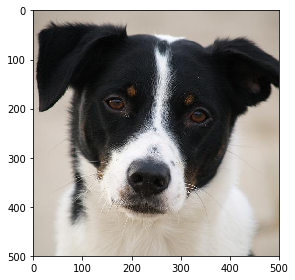

In [28]:
io.imshow(poza_daria)

In [28]:

validation

[0.9615873871975289,
 0.9615873871975289,
 0.959933862465388,
 0.9382684676790524,
 0.962242567445254]

In [29]:
train

[0.944883894358822,
 0.944883894358822,
 0.9737645379523766,
 0.9778976118279293,
 0.9777704389048553]

In [38]:
train

[0.944883894358822,
 0.944883894358822,
 0.9737645379523766,
 0.9778976118279293,
 0.9777704389048553,
 0.97784674291642,
 0.9831370744663479,
 0.9829463183790408]

In [39]:
validation

[0.9615873871975289,
 0.9615873871975289,
 0.959933862465388,
 0.9382684676790524,
 0.962242567445254,
 0.9786314028451473,
 0.9771050728480344,
 0.9669295453463237]